# **Импорт библиотек**

In [ ]:
import pandas as pd
import numpy as np
from keras import backend as K
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Layer
import tensorflow as tf

np.random.seed(35)

Перевод данных в вид датафрейма

In [ ]:
# Данные по годам
data = [
    [83.62, 80.08, 74.16, 69.55, 65.82, 64.31, 57.93, 54.48, 51.27, 48.52, 50.44, 51.88],  # 1999
    [53.81, 53.24, 48.95, 43.50, 37.70, 34.50, 34.13, 32.12, 27.22, 26.47, 27.33, 32.38],  # 2000
    [30.13, 30.12, 26.89, 19.82, 19.60, 21.43, 22.43, 19.27, 17.27, 18.57, 20.15, 20.96],  # 2001
    [32.10, 35.20, 36.88, 38.12, 35.25, 28.84, 28.75, 24.18, 21.78, 22.98, 26.32, 28.67],  # 2002
    [29.81, 28.50, 28.16, 30.28, 27.95, 23.02, 21.96, 21.16, 23.22, 23.14, 27.52, 26.79]   # 2003
]

data_plot = data
# Список годов
years = [1999, 2000, 2001, 2002, 2003]
# Список месяцев
months = np.arange(1,13)
# Создание датафрейма
df = pd.DataFrame(data, index=years, columns=months)


# Преобразование данных
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Разделение на обучающую и тестовую выборки
train_data = data_scaled[:-1]

print((train_data))
test_data = data_scaled[-1]

print(len(test_data))

[[1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.        ]
 [0.44601375 0.47964327 0.46668077 0.47617133 0.39160537 0.3048041
  0.3383375  0.36495314 0.29264706 0.26377295 0.23704193 0.36934023]
 [0.00594685 0.03140752 0.         0.         0.         0.
  0.01306644 0.         0.         0.         0.         0.        ]
 [0.04255715 0.12989531 0.21133912 0.36798713 0.33859801 0.17280784
  0.18876842 0.13944902 0.13264706 0.14724541 0.20369759 0.24935317]]
12


Был выведен график изменений изначальных значений

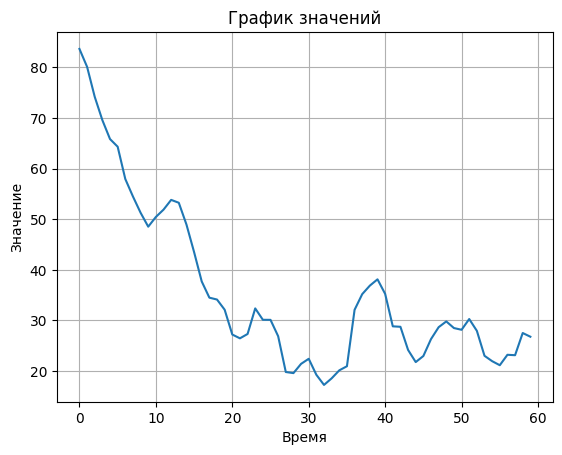

In [ ]:
data_flaten = np.ravel(data_plot)
plt.plot(np.arange(0,60),data_flaten)
plt.grid()
plt.xlabel("Время")
plt.ylabel("Значение")
plt.title("График значений")
plt.show()

# **Модель RBF**

Создание модели RBF с тремя слоями (входной, скрытый, выходной). На скрытом слое используется радиально базисная функция активации.

Для реализации слоя с функцией активации RBF был создан класс, представляющий собой слой нейронной сети. Конструктор получает на вход units - количество центров, input_dim - количество входных данных

In [ ]:
class RBFLayer(Layer):
    def __init__(self, units, input_dim, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units # кол-во центров rbf
        self.input_dim = input_dim # кол-во входных

    def build(self, input_shape):
      # вычисляются веса для центров
        self.centers = self.add_weight(shape=(self.units, self.input_dim),
                                       initializer='uniform',
                                       trainable=True)
        super(RBFLayer, self).build(input_shape) # вызывает родительский layer передает в него свои параметры
  # вызывается каждый раз когда через слой проходят данные
    def call(self, inputs):
        # вычисляется попарное евклидовое расстояние между входными векторами и центрами функции
        distances = tf.sqrt(tf.reduce_sum(tf.square(inputs[:, None, :] - self.centers[None, :, :]), axis=-1))
        return tf.exp(-distances**2)

Создание модели и её обучение.

In [ ]:
# Создание модели
model = Sequential()
model.add(Dense(12, input_dim=12))
model.add(RBFLayer(10, input_dim = 12))  # кастомный слой RBF
model.add(Dense(12))
model.compile(loss='mae', optimizer='adam')

# Обучение модели
model.fit(train_data, train_data, epochs=200, batch_size=1, verbose=0)

# Предсказание на 12 месяцев вперед
predictions = model.predict(np.array([test_data]))
predictions = scaler.inverse_transform(predictions)[0]


1/1 [==============================] - 0s 359ms/step


Построение графиков. Предсказание пятого года, на основе предыдущих четырех.

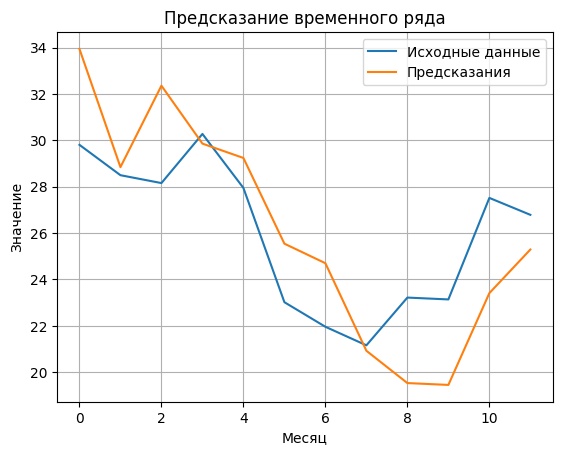

[4.13805908 0.34730721 4.20135864 0.41761902 1.29317741 2.52530716
 2.74188522 0.23520676 3.68868515 3.68867172 4.10778954 1.4968615 ]


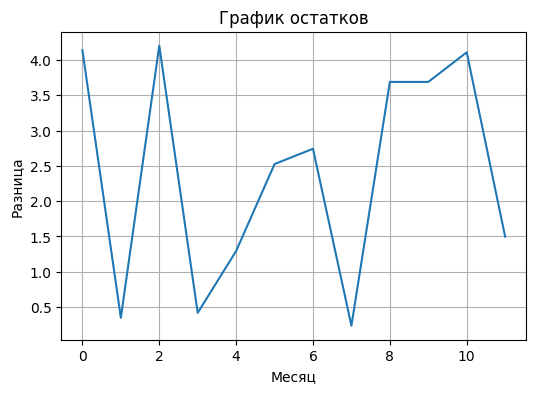

In [ ]:
# График исходных данных и предсказаний
plt.plot(data[-1], label='Исходные данные')
plt.plot(predictions, label='Предсказания')
plt.xlabel('Месяц')
plt.ylabel('Значение')
plt.title('Предсказание временного ряда')
plt.legend()
plt.grid()
plt.show()

# Гистограмма остатков
residuals = np.abs(data[-1] - predictions)
print(residuals)
plt.figure(figsize=(6, 4))
#plt.hist(residuals, bins=np.arange(0,12), edgecolor='black')
plt.plot(np.arange(0,12),residuals )
plt.xlabel('Месяц')
plt.ylabel('Разница')
plt.title('График остатков')
plt.grid()
plt.show()

По данным графикам можно сделать вывод о том, что предсказания данной модели близки к исходным данным, что говорит нам о том, что RBF модель с подобными параметрами (200 эпох обучения, 10 нейронов на скрытом слое, функция активации - функция Гаусса) достаточно точно предсказывает значения, данная модель подходит для работы с временными рядами.

Предсказание шестого года на основе пяти предыдуших.

In [ ]:
# данные предыдущих пяти лет
data = [
    [83.62, 80.08, 74.16, 69.55, 65.82, 64.31, 57.93, 54.48, 51.27, 48.52, 50.44, 51.88],  # 1999
    [53.81, 53.24, 48.95, 43.50, 37.70, 34.50, 34.13, 32.12, 27.22, 26.47, 27.33, 32.38],  # 2000
    [30.13, 30.12, 26.89, 19.82, 19.60, 21.43, 22.43, 19.27, 17.27, 18.57, 20.15, 20.96],  # 2001
    [32.10, 35.20, 36.88, 38.12, 35.25, 28.84, 28.75, 24.18, 21.78, 22.98, 26.32, 28.67],  # 2002
    [29.81, 28.50, 28.16, 30.28, 27.95, 23.02, 21.96, 21.16, 23.22, 23.14, 27.52, 26.79]   # 2003
]
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
# Создание модели
model = Sequential()
model.add(Dense(12, input_dim=12))
model.add(RBFLayer(120, input_dim = 12))  # кастомный слой RBF
model.add(Dense(12))
model.compile(loss='mae', optimizer='adam')

 # Assuming 12 months of data per year
model.fit(data, data, epochs=300, batch_size=5, verbose=0)


test_data = data[-1]
test_data_scaled = scaler.transform([test_data])  # Масштабирование тестовых данных
predictions_scaled = model.predict(test_data_scaled)
predictions = scaler.inverse_transform(predictions_scaled)[0]  # Обратное масштабирование
print(predictions)

1/1 [==============================] - 0s 76ms/step
[54.339363 49.039738 49.318924 48.525078 41.926083 37.069744 31.760406
 33.49795  30.86494  27.406765 33.40336  34.42099 ]


Построение графиков

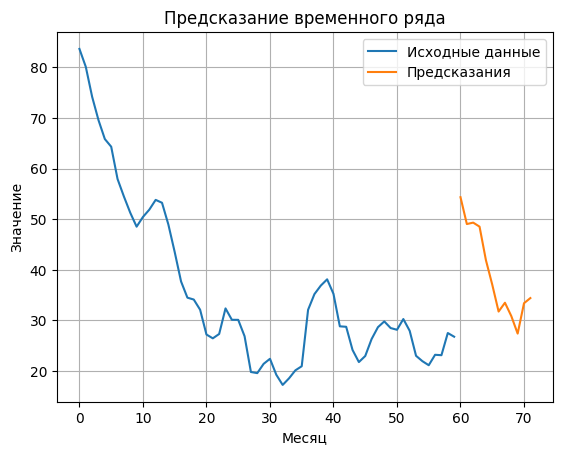

[27.549362   22.249737   22.528923   21.735077   15.136082   10.279743
  4.9704056   6.7079506   4.0749397   0.61676407  6.6133575   7.630989  ]


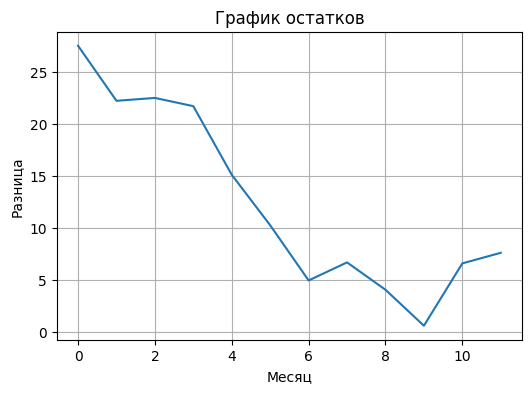

In [ ]:
data = np.ravel(data)
# График исходных данных и предсказаний
plt.plot( np.arange(0,60),data, label='Исходные данные')
plt.plot(np.arange(60,72),predictions, label='Предсказания')
plt.xlabel('Месяц')
plt.ylabel('Значение')
plt.title('Предсказание временного ряда')
plt.legend()
plt.grid()
plt.show()



# Гистограмма остатков
residuals = np.abs(data[-1] - predictions)
print(residuals)
plt.figure(figsize=(6, 4))
#plt.hist(residuals, bins=np.arange(0,12), edgecolor='black')
plt.plot(np.arange(0,12),residuals )
plt.xlabel('Месяц')
plt.ylabel('Разница')
plt.title('График остатков')
plt.grid()
plt.show()

По данным графикам, можно сделать вывод о том, что данная модель недостаточно точно предсказывает значения для следующего года, разница между последним зафиксированным годом и новым значительна.